In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [33]:
df = pd.read_csv("PJME_hourly.csv")
pjme = pd.read_csv("PJME_hourly.csv", index_col=[0], parse_dates=[0])

In [34]:
df["Datetime"] = pd.to_datetime(df["Datetime"])

#Date features
df["Hour"] = df["Datetime"].dt.hour
df["Day"] = df["Datetime"].dt.dayofweek
df["Month"] = df["Datetime"].dt.month
df["Year"] = df["Datetime"].dt.year
df["Q"] = df["Datetime"].dt.quarter
df["Dayofyear"] = df["Datetime"].dt.dayofyear
df["Dayofmonth"] = df["Datetime"].dt.day
df["Weekofyear"] = df["Datetime"].dt.weekofyear

df["Drop_me"] = df["Datetime"].dt.strftime("%m-%d")

df.index = df["Datetime"]
df = df.drop(["Datetime"],axis=1)

/var/folders/yw/42xscsr10q573yfmjt23989r0000gn/T/ipykernel_4052/3486507697.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Weekofyear"] = df["Datetime"].dt.weekofyear


In [35]:
df.head()

,PJME_MW,Hour,Day,Month,Year,Q,Dayofyear,Dayofmonth,Weekofyear,Drop_me
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,2002,4,365,31,1,12-31
2002-12-31 02:00:00,25147.0,2,1,12,2002,4,365,31,1,12-31
2002-12-31 03:00:00,24574.0,3,1,12,2002,4,365,31,1,12-31
2002-12-31 04:00:00,24393.0,4,1,12,2002,4,365,31,1,12-31
2002-12-31 05:00:00,24860.0,5,1,12,2002,4,365,31,1,12-31


In [36]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [37]:
df.isnull().sum()

PJME_MW       0
Hour          0
Day           0
Month         0
Year          0
Q             0
Dayofyear     0
Dayofmonth    0
Weekofyear    0
Drop_me       0
dtype: int64

In [38]:
df.dtypes

PJME_MW       float64
Hour            int64
Day             int64
Month           int64
Year            int64
Q               int64
Dayofyear       int64
Dayofmonth      int64
Weekofyear      int64
Drop_me        object
dtype: object

Text(0.0, 1.0, 'Consumption distribution')

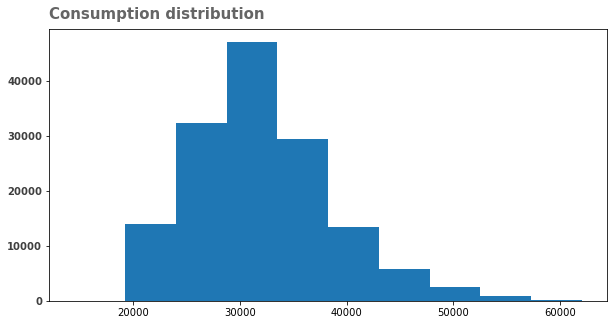

In [39]:
ax, fig = plt.subplots(figsize=(10,5))

plt.hist(df["PJME_MW"])

plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("",alpha=0.75, weight="bold")
plt.ylabel("",alpha=0.75, weight="bold")

plt.title("Consumption distribution", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

/Users/anveshadutta/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/anveshadutta/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/anveshadutta/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

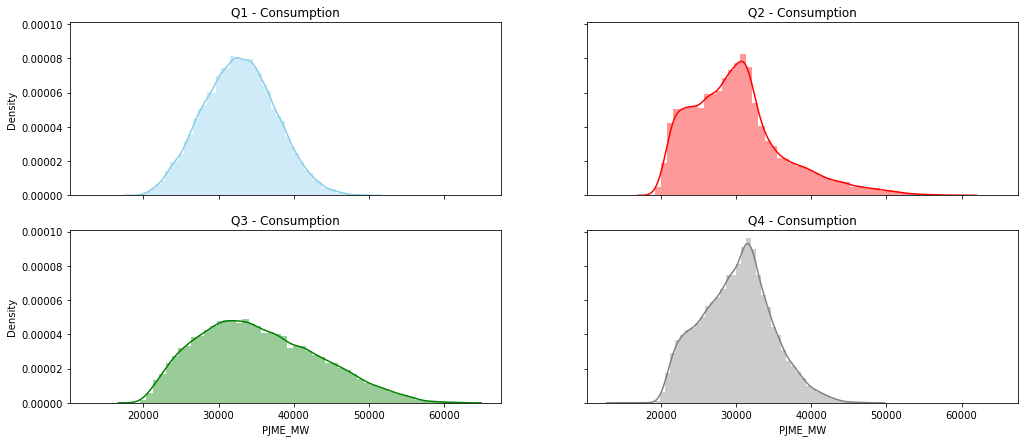

In [40]:
#Data prep
Q1 = df[df["Q"]==1]
Q2 = df[df["Q"]==2]
Q3 = df[df["Q"]==3]
Q4 = df[df["Q"]==4]

#Plot
fig,axes = plt.subplots(2,2,figsize=(17,7),sharex=True,sharey=True)

sns.distplot(Q1["PJME_MW"],color="skyblue", ax=axes[0,0]).set_title("Q1 - Consumption")
sns.distplot(Q2["PJME_MW"],color="red", ax=axes[0,1]).set_title("Q2 - Consumption")
sns.distplot(Q3["PJME_MW"],color="green", ax=axes[1,0]).set_title("Q3 - Consumption")
sns.distplot(Q4["PJME_MW"],color="gray", ax=axes[1,1]).set_title("Q4 - Consumption")

del Q1, Q2, Q3, Q4

Text(0.0, 1.0, 'Mean daily consumption')

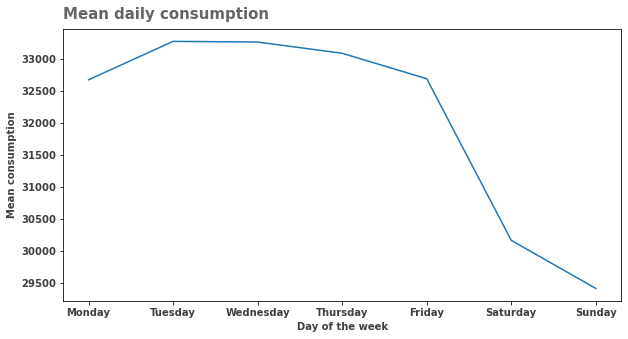

In [41]:
#Data prep
mean_per_day = df.groupby("Day")["PJME_MW"].agg(["mean"])

#Plot
fig, ax = plt.subplots(figsize=(10,5))


plt.plot(mean_per_day.index,mean_per_day["mean"])

plt.xticks(mean_per_day.index, ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"], alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Day of the week",alpha=0.75, weight="bold")
plt.ylabel("Mean consumption",alpha=0.75, weight="bold")

plt.title("Mean daily consumption", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

#del mean_per_day

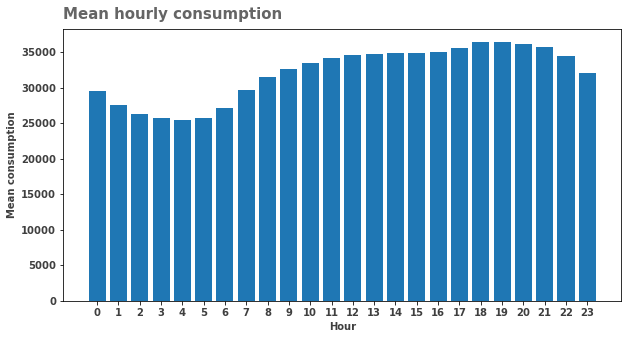

In [42]:
#Data
mean_per_hour = df.groupby("Hour")["PJME_MW"].agg(["mean"])

#Plot
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(mean_per_hour.index, mean_per_hour["mean"])

plt.xticks(range(24),alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Hour",alpha=0.75, weight="bold")
plt.ylabel("Mean consumption",alpha=0.75, weight="bold")

plt.title("Mean hourly consumption", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

del mean_per_hour

Text(0.0, 1.0, 'Consumption over time')

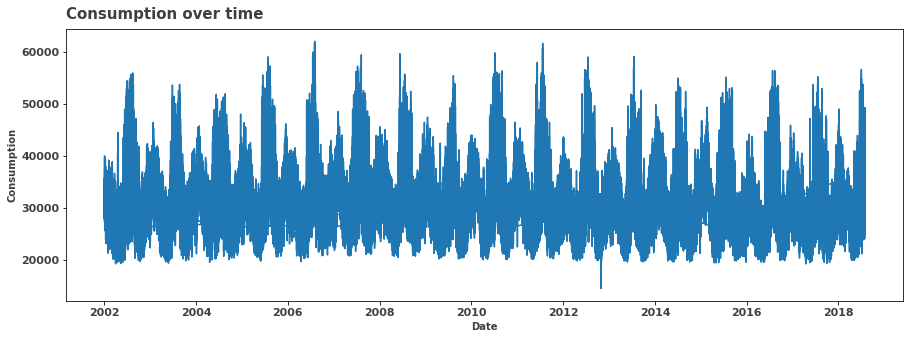

In [43]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(df.index,df["PJME_MW"])

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Consumption over time", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

New code

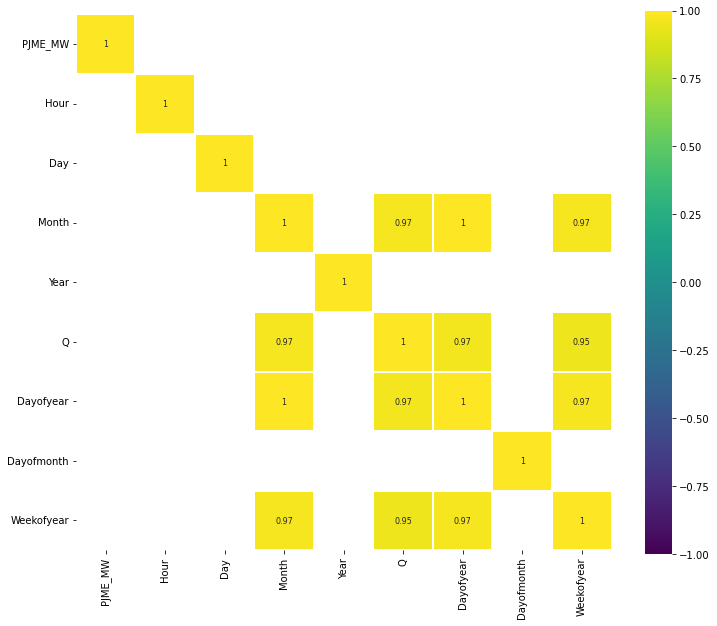

In [44]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Test/Train split

In [45]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

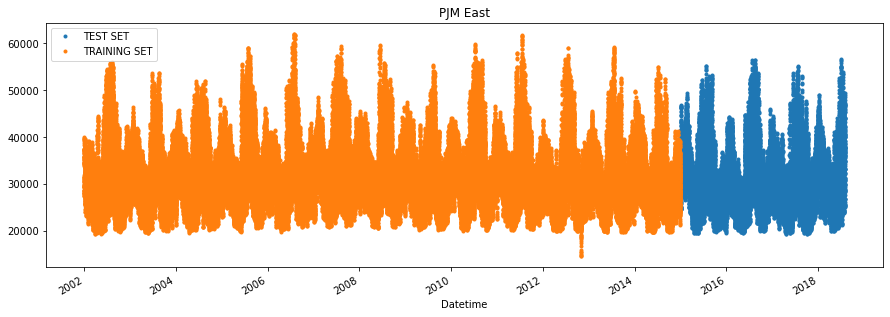

In [46]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

Creating time series features

In [47]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [48]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

/var/folders/yw/42xscsr10q573yfmjt23989r0000gn/T/ipykernel_4052/256030966.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
/var/folders/yw/42xscsr10q573yfmjt23989r0000gn/T/ipykernel_4052/256030966.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


creating XGBoost Model

In [49]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

/Users/anveshadutta/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

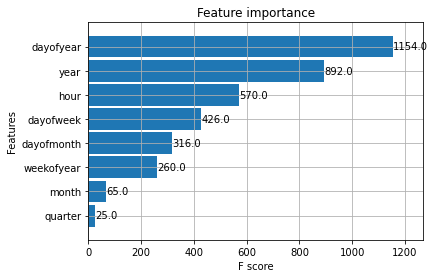

In [50]:
_ = plot_importance(reg, height=0.9)

In [51]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

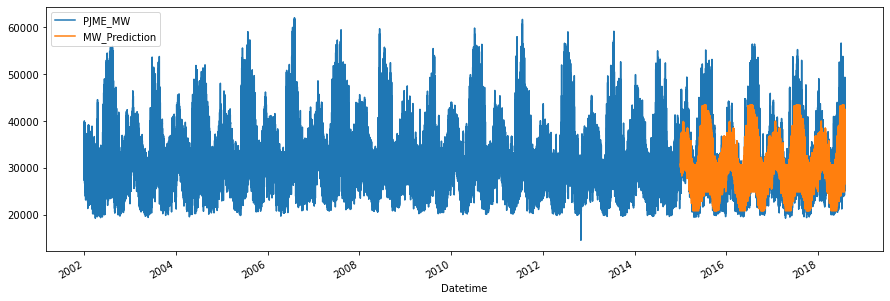

In [52]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))